In [1]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [54]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from info_gain import info_gain
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [3]:
df = pd.read_csv('./data/data.csv')

In [4]:
df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [5]:
df.shape

(233154, 41)

## First of all, you will identify fields with more than 50% null data. These fields should be removed from analysis.



### But EMPLOYMENT_TYPE has 7661 null values

In [8]:
null_data= df.isnull().sum().sort_values(ascending=False)
percent_missing= (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

missing_data= pd.concat([null_data, percent_missing], axis=1, keys=['Total missing values', 'Percent missing'])
missing_data.head(8)

,Total missing values,Percent missing
EMPLOYMENT_TYPE,7661,0.032858
PERFORM_CNS_SCORE,0,0.000000
DRIVING_FLAG,0,0.000000
VOTERID_FLAG,0,0.000000
PAN_FLAG,0,0.000000
AADHAR_FLAG,0,0.000000
MOBILENO_AVL_FLAG,0,0.000000
EMPLOYEE_CODE_ID,0,0.000000


## Check how many unique value in EMPLOYMENT_TYPE

In [9]:
df.EMPLOYMENT_TYPE.unique()

array(['Salaried', 'Self employed', nan], dtype=object)

## drop rows which has null values 

In [10]:
df.dropna(inplace=True)

## how many peole are self employed and salaried

<AxesSubplot:>

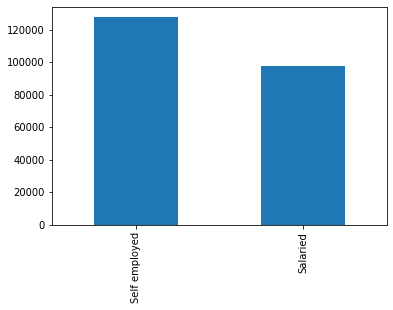

In [11]:
df.EMPLOYMENT_TYPE.value_counts().plot(kind='bar')

## AVERAGE_ACCT_AGE and CREDIT_HISTORY_LENGTH both have this '0yrs 0mon' format
### 1.   so we will convert into month number
### 2.   drop original column from data

In [12]:
df[['AVERAGE_ACCT_Yr','AVERAGE_ACCT_Month']] = df['AVERAGE_ACCT_AGE'].str.split("yrs",expand=True)
df[['AVERAGE_ACCT_Month','AVERAGE_ACCT_MonthEMPTY']] = df['AVERAGE_ACCT_Month'].str.split("mon",expand=True)
df["AVERAGE_ACCT_AGE"]= df["AVERAGE_ACCT_Yr"].astype(int)+round(((df["AVERAGE_ACCT_Month"].astype(int))/12),2)
df.drop(columns= ["AVERAGE_ACCT_Yr","AVERAGE_ACCT_Month",'AVERAGE_ACCT_MonthEMPTY'],inplace=True)


df[['CREDIT_HISTORY_LENGTH_Yr','CREDIT_HISTORY_LENGTH_Month']] = df['CREDIT_HISTORY_LENGTH'].str.split("yrs",expand=True)
df[['CREDIT_HISTORY_LENGTH_Month','CREDIT_HISTORY_LENGTH_MonthEMPTY']] = df['CREDIT_HISTORY_LENGTH_Month'].str.split("mon",expand=True)
df["CREDIT_HISTORY_LENGTH"]= df["CREDIT_HISTORY_LENGTH_Yr"].astype(str).astype(int)+round(((df["CREDIT_HISTORY_LENGTH_Month"].astype(str).astype(int))/12),2)
df = df.drop(columns= ["CREDIT_HISTORY_LENGTH_Yr","CREDIT_HISTORY_LENGTH_Month",'CREDIT_HISTORY_LENGTH_MonthEMPTY'])


## DATE_OF_BIRTH and DISBURSAL_DATE both have this '03-08-2018' format perform operation on both columns
### 1.   so we will extract total age in yrars
### 2.   so we will extract total age in days
### 2.   drop original columns from data  

In [13]:

df['DATE_OF_BIRTH'] =  pd.to_datetime(df['DATE_OF_BIRTH'], format='%d-%m-%Y')
df['ApplicantAgeInDays']=pd.to_datetime(datetime.date.today())-df['DATE_OF_BIRTH']
df['ApplicantAgeInDays'] = df['ApplicantAgeInDays'].astype(str).str.split(" ", expand = True)[0].astype(int)
df['AGE'] = ((pd.to_datetime(datetime.date.today()) - df['DATE_OF_BIRTH']) / 365).apply(lambda x: float(x.days))


df['DISBURSAL_DATE'] =  pd.to_datetime(df['DISBURSAL_DATE'], format='%d-%m-%Y')
df['DisbursalAgeInDays']=pd.to_datetime(datetime.date.today())-df['DISBURSAL_DATE']
df['DisbursalAgeInDays'] = df['DisbursalAgeInDays'].astype(str).str.split(" ", expand = True)[0].astype(int)
df['DisAGE'] = ((pd.to_datetime(datetime.date.today()) - df['DATE_OF_BIRTH']) / 365).apply(lambda x: float(x.days))


df = df.drop(columns= ["DISBURSAL_DATE","DATE_OF_BIRTH"])

# Total number of Loan Defauter and Non

In [14]:
print('~> Non Loan Defulter :\n   {}%'.format(100 - round(df['LOAN_DEFAULT'].mean()*100, 2)))
print('\n~> Loan Deault:\n   {}%'.format(round(df['LOAN_DEFAULT'].mean()*100, 2)),'\n')


~> Non Loan Defulter :
   78.28%

~> Loan Deault:
   21.72% 



## bar chart for totol number of deafult and non

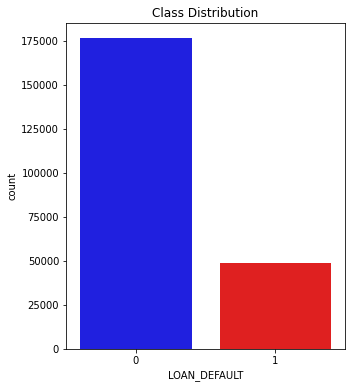

In [15]:
my_pal = {0: 'blue', 1: 'red'}

plt.figure(figsize = (5, 6))
ax = sns.countplot(x = 'LOAN_DEFAULT', data = df, palette = my_pal)
plt.title('Class Distribution')
plt.show()

## show in dataframe for totol number of deafult and non

In [16]:
x = df.groupby('LOAN_DEFAULT').count()['UNIQUEID'].reset_index().sort_values(by='UNIQUEID',ascending=False)
x.style.background_gradient(cmap='summer')

,LOAN_DEFAULT,UNIQUEID
0,0,176526
1,1,48967


## we can check that the data is unbalance

## pie chart for totol number of deafult and non

<AxesSubplot:ylabel='LOAN_DEFAULT'>

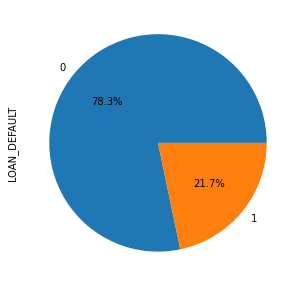

In [17]:
df['LOAN_DEFAULT'].astype(int).value_counts().plot(kind='pie',figsize=(8,5),autopct='%1.1f%%')


## Scatter plot of some features

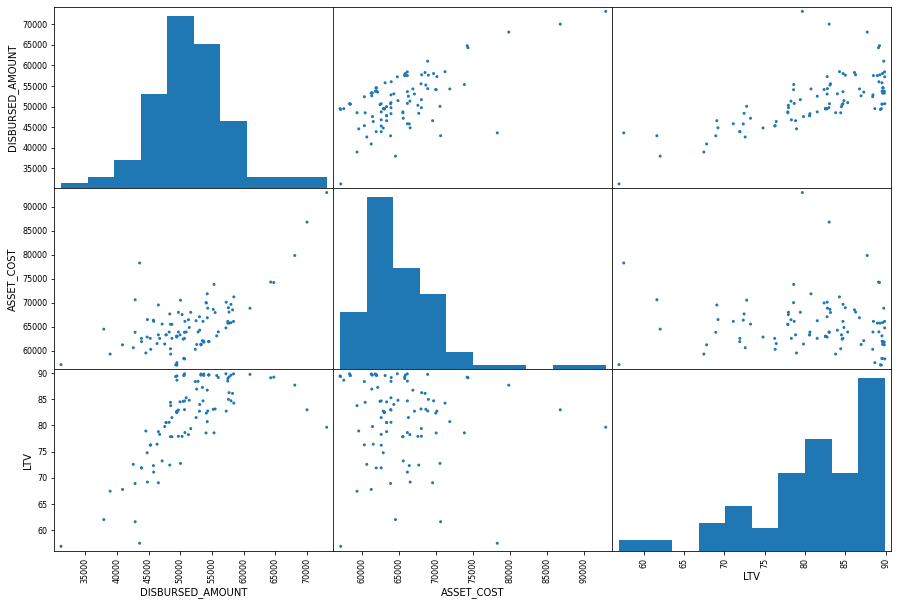

In [18]:
pd.plotting.scatter_matrix(df[['DISBURSED_AMOUNT','ASSET_COST','LTV']][:100],figsize=(15,10),diagonal='hist',alpha=1)
plt.show()

##  show the distribution of quantitative data across DISBURSED_AMOUNT , ASSET_COST

<AxesSubplot:xlabel='LOAN_DEFAULT', ylabel='ASSET_COST'>

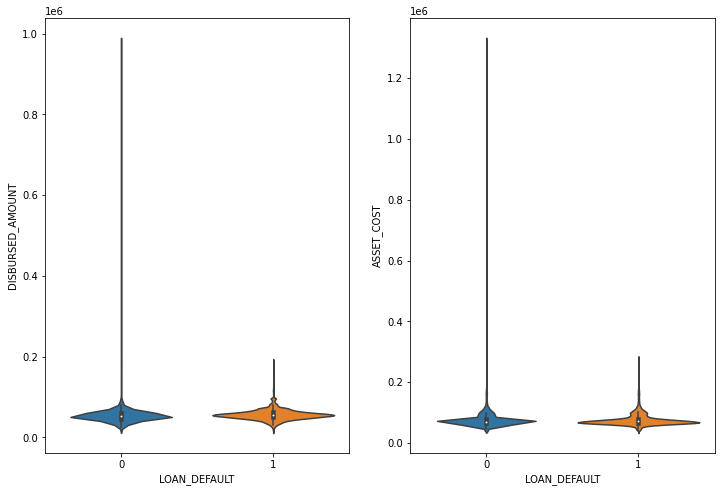

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)

sns.violinplot(x = 'LOAN_DEFAULT', y = 'DISBURSED_AMOUNT', data = df[0:],kind="violin",height=4, aspect=.7)

plt.subplot(1,2,2)

sns.violinplot(x = 'LOAN_DEFAULT', y = 'ASSET_COST', data = df[0:])

##  show the distribution of quantitative data across LTV

<AxesSubplot:xlabel='LOAN_DEFAULT', ylabel='LTV'>

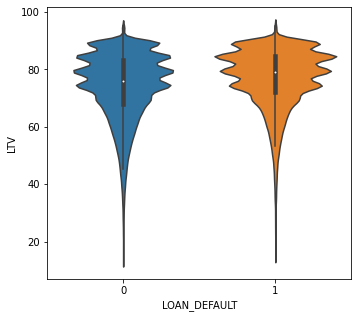

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)

sns.violinplot(x = 'LOAN_DEFAULT', y = 'LTV', data = df[0:])

## show the distribution of quantitative data across AGE

c:\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AGE', ylabel='Density'>

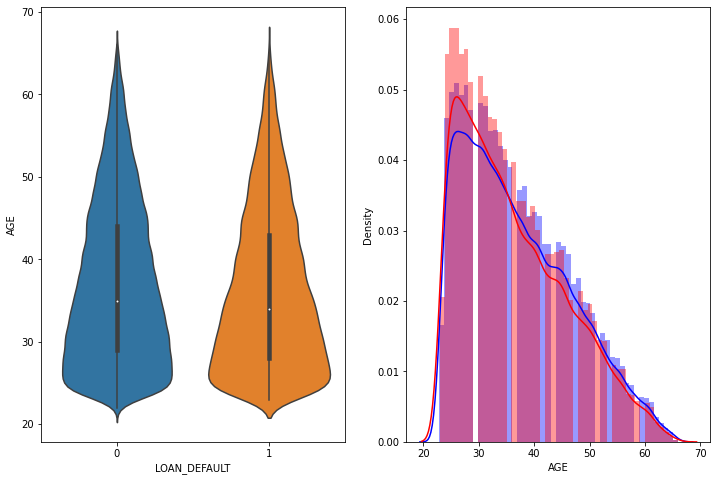

In [21]:


plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)

sns.violinplot(x = 'LOAN_DEFAULT', y = 'AGE', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['LOAN_DEFAULT'] == 0]['AGE'][0:] , label = "0", color = 'blue')
sns.distplot(df[df['LOAN_DEFAULT'] == 1]['AGE'][0:] , label = "1" , color = 'red' )

## show the distribution of quantitative data across MANUFACTURER_ID

c:\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


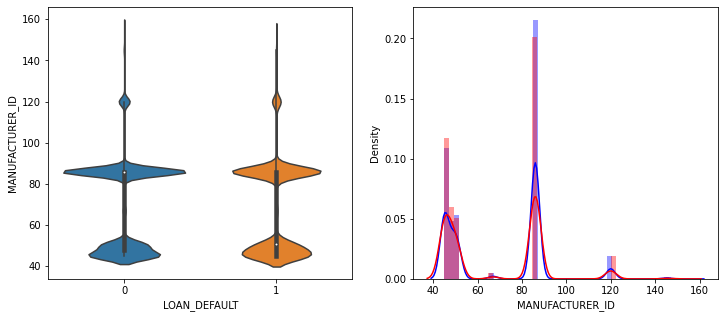

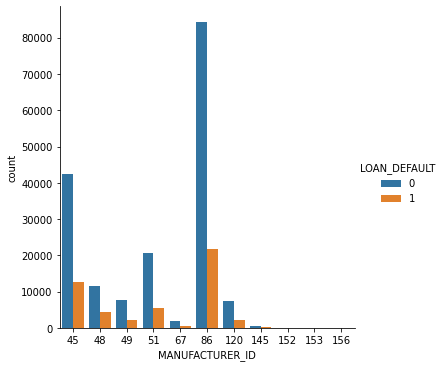

In [22]:

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)

sns.violinplot(x = 'LOAN_DEFAULT', y = 'MANUFACTURER_ID', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['LOAN_DEFAULT'] == 0]['MANUFACTURER_ID'][0:] , label = "0", color = 'blue')
sns.distplot(df[df['LOAN_DEFAULT'] == 1]['MANUFACTURER_ID'][0:] , label = "1" , color = 'red' )

sns.catplot(data=df,kind='count',x='MANUFACTURER_ID',hue='LOAN_DEFAULT')

## box plot for Age and Disbursal Age
##  Age has no impact on the defaulting, aslo same as for Disbursal Age

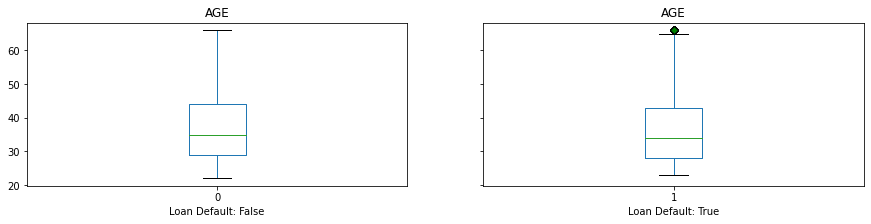

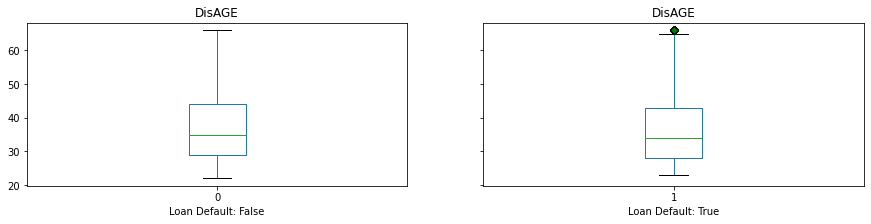

In [23]:
cols = ['AGE', 'DisAGE']
green_diamond = dict(markerfacecolor='g', marker='D')
for j, col in enumerate(cols):
    fig, axs = plt.subplots(1, len(cols), figsize=(15, 3), sharey=True)
    for i, (val, group) in enumerate(df.groupby('LOAN_DEFAULT')):
        group[col].plot.box( ax=axs[i], label=val,flierprops=green_diamond)
        axs[i].set_title(col)
        axs[i].set_xlabel("Loan Default: %s"%bool(val))
    plt.show()

## hist for the LTV feature

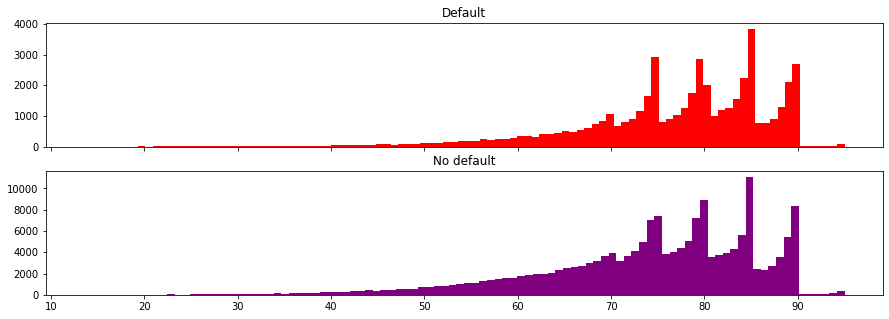

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))

bins = 100

ax1.hist(df.LTV[df.LOAN_DEFAULT == 1], bins = bins, color = 'red')
ax1.set_title('Default')

ax2.hist(df.LTV[df.LOAN_DEFAULT == 0], bins = bins, color = 'purple')
ax2.set_title('No default')

plt.show()

## which feauture is contributing to LOAN_DEFAULT and find the corelation 
## find the which is not plaing good role with LOAN_DEAFULT

### we first use primary and secondary acounts for correlation

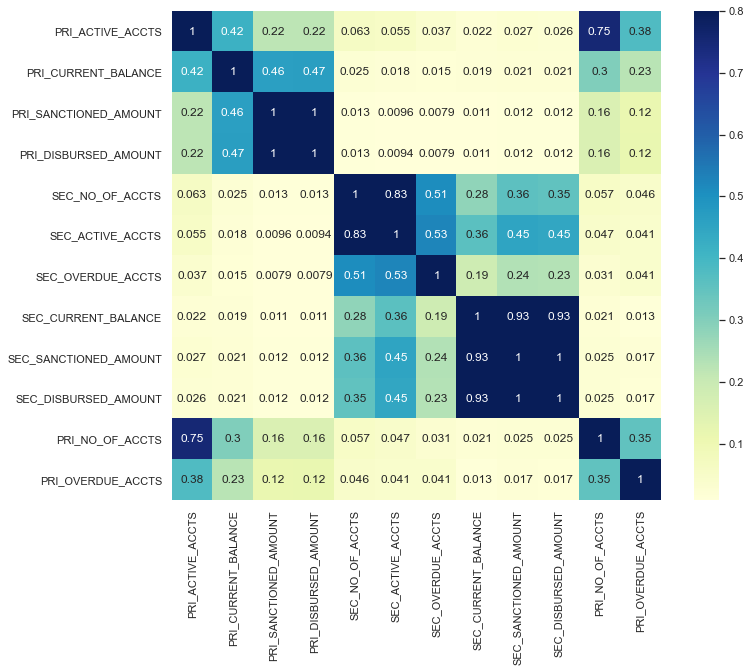

In [25]:
sns.set()

cols = df[['PRI_ACTIVE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 
              'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
              'SEC_DISBURSED_AMOUNT',  'PRI_NO_OF_ACCTS', 'PRI_OVERDUE_ACCTS']]
corr = cols.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot=True, vmax=.8, square=True,cmap = 'YlGnBu');

## pick some other feature to find correation

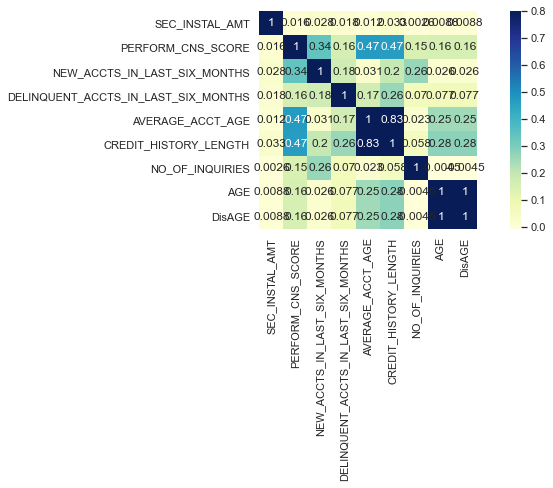

In [26]:
#Highly Correlated
sns.set()

cols = df[['SEC_INSTAL_AMT', 'PERFORM_CNS_SCORE','NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 
              'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES','AGE', 'DisAGE']]
corr = cols.corr()
f, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(corr, annot=True, vmax=.8, square=True,cmap = 'YlGnBu');

## apply for whole data , correlation

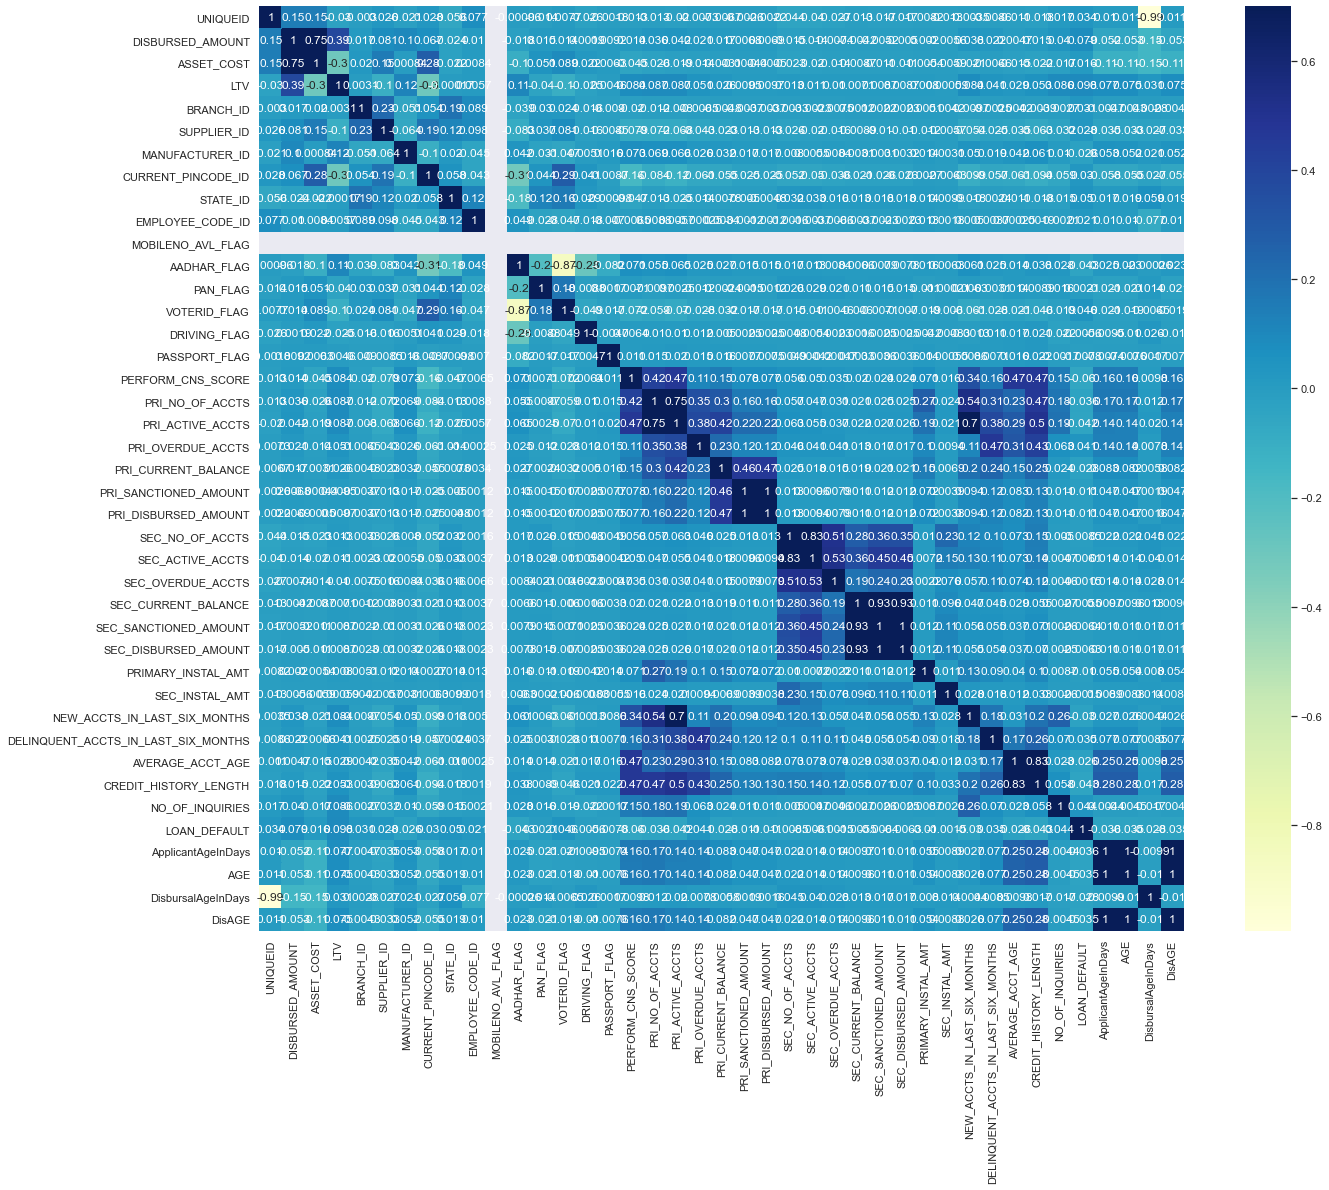

In [27]:
corr = df.corr()
f, ax = plt.subplots(figsize=(22, 17))
sns.heatmap(corr, annot=True, vmax=.7, square=True,cmap = 'YlGnBu');

## without correlation value . correlation heatmap 

<AxesSubplot:>

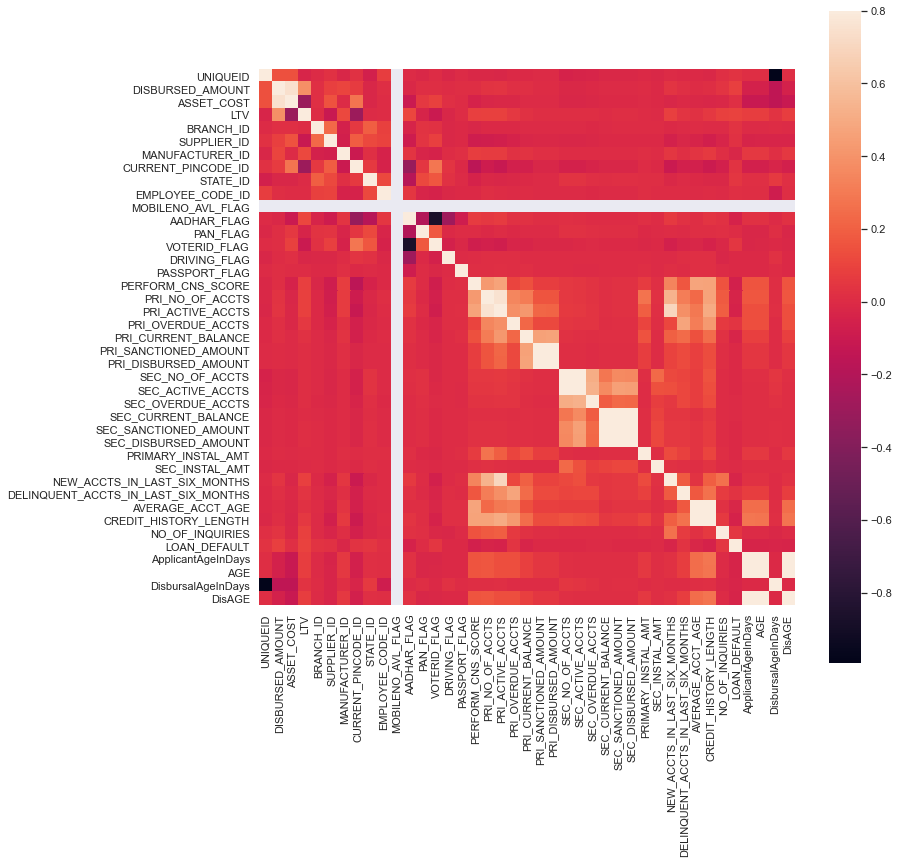

In [28]:
corr_mat = df.corr()
f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(corr_mat, vmax = 0.8, square= True)

## As we know the number of features is more tha 30 , for better visulization and better readibility we pick those column which has highly correlated

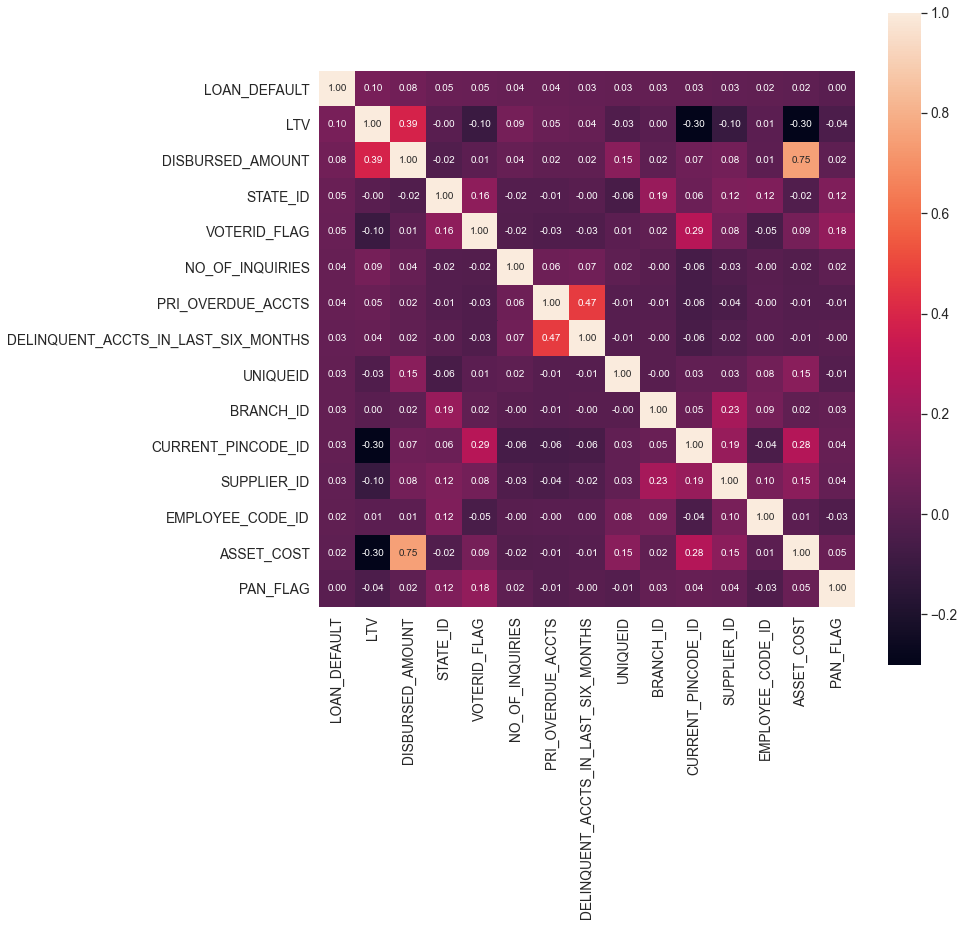

In [29]:
k = 15
cols = corr_mat.nlargest(k, 'LOAN_DEFAULT')['LOAN_DEFAULT'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
f,ax = plt.subplots(figsize = (12,12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## bar cha show which column has highly positive and negative correlated

<AxesSubplot:>

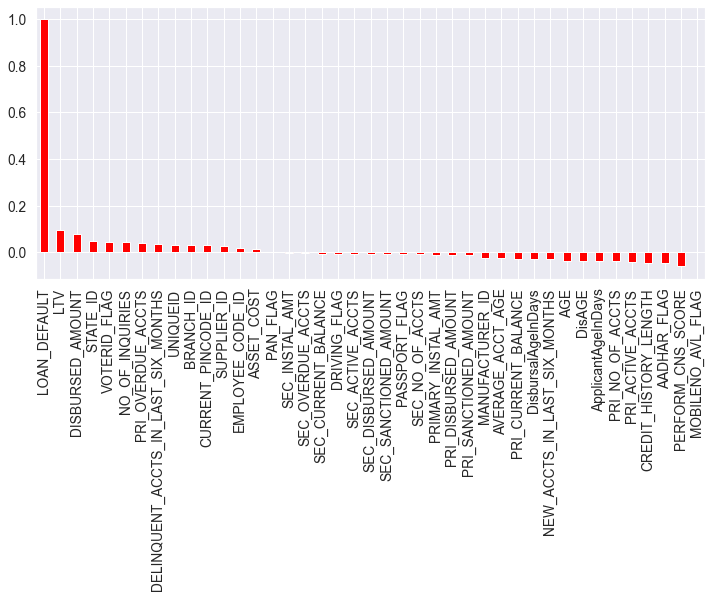

In [30]:
f,ax = plt.subplots(figsize = (12,5))
df.corr()['LOAN_DEFAULT'].sort_values(ascending = False).plot.bar(color='red')

## Explore data further for some analysis

## check the distribution of DISBURSED_AMOUNT

c:\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


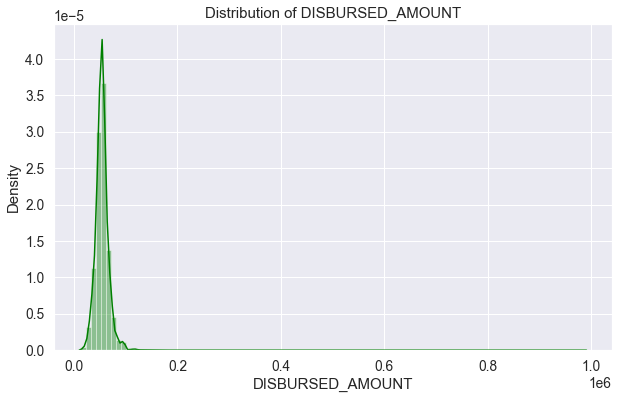

In [32]:

plt.figure(figsize=(10,6))
plt.title("Distribution of %s" % 'DISBURSED_AMOUNT')
sns.distplot(df['DISBURSED_AMOUNT'].dropna(),color='green', kde=True,bins=100)
plt.show()

 ## check the distribution of DISBURSED_AMOUNT using boxplot

c:\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


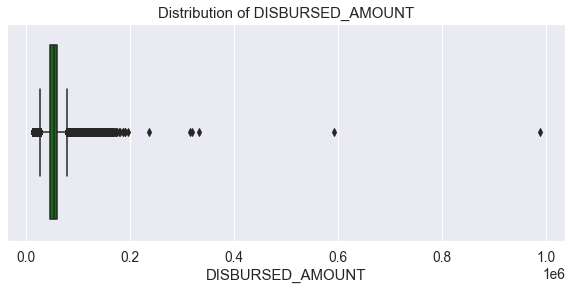

In [33]:


plt.figure(figsize=(10,4))
plt.title("Distribution of %s" % 'DISBURSED_AMOUNT')
sns.boxplot(df['DISBURSED_AMOUNT'].dropna(),color='green')

plt.show()


 ## check the distribution of ASSET_COST using boxplot

c:\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


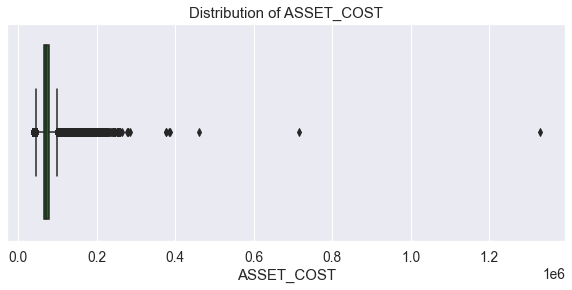

In [34]:
plt.figure(figsize=(10,4))
plt.title("Distribution of %s" % 'ASSET_COST')
sns.boxplot(df['ASSET_COST'].dropna(),color='green')
plt.show()

 ## check the distribution of LTV using boxplot

c:\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


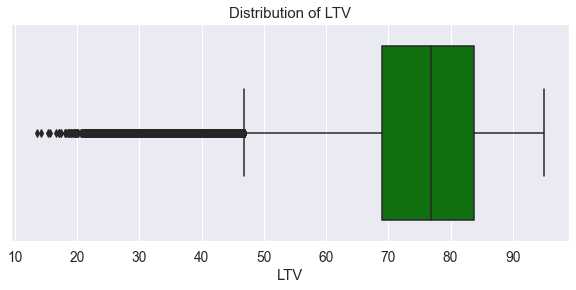

In [35]:
plt.figure(figsize=(10,4))
plt.title("Distribution of %s" % 'LTV')
sns.boxplot(df['LTV'].dropna(),color='green')
plt.show()

### drop UNIQUEID column becuase  df.UNIQUEID.shape == df.LOAN_DEFAULT.shape

In [36]:

df = df.drop('UNIQUEID', axis=1)

## during analyzing the distribution of ASSET_COST and distribution of DISBURSED_AMOUNT using boxplot
### we find some outlinear in feature , So we fisrt remove the outliear

In [37]:
def removeOutlier(dataSet, feature):    
    q1,q3=dataSet[feature].quantile(0.25),dataSet[feature].quantile(0.75)

    IQR=q3-q1
    lowerLimit,UpperLimit = q1 - 1.5 * IQR,q3 + 1.5 * IQR 
    dataSet = dataSet[dataSet[feature]< UpperLimit]
    dataSet = dataSet[dataSet[feature]> lowerLimit]
    return dataSet

df = removeOutlier(df, 'DISBURSED_AMOUNT')
df = removeOutlier(df, 'ASSET_COST')

### first convert data to numerc form

In [45]:
le = preprocessing.LabelEncoder()
for i in df.columns:
    le.fit(df[i])
    df[i] = le.transform(df[i])

## seperate the lable and features

In [46]:
X= df[set(df.columns)-set(['LOAN_DEFAULT'])] 
Y = df['LOAN_DEFAULT']

## For handling unblance data we apply sampling techinque 

In [47]:
print('Before Resampling:')
print(df['LOAN_DEFAULT'].value_counts())
df_majority = df[df['LOAN_DEFAULT']==0]
df_minority = df[df['LOAN_DEFAULT']==1]


df_minority_upsampled = resample(df_minority, replace=True,n_samples=len(df_majority),random_state=123)              
df = pd.concat([df_majority, df_minority_upsampled])
print('\n After Resampling:')
print(df['LOAN_DEFAULT'].value_counts())


Before Resampling:
1    153452
0    153452
Name: LOAN_DEFAULT, dtype: int64

 After Resampling:
1    153452
0    153452
Name: LOAN_DEFAULT, dtype: int64


## apply SMOTE algorithm for balancing the data

In [48]:
from imblearn.over_sampling import SMOTE



sm = SMOTE(random_state=27)
XSmote, YSmote = sm.fit_sample(X, Y)


## split data into training and testing

In [49]:

x_train, x_test, y_train, y_test = train_test_split(X, Y)

x_trainS, x_testS, y_trainS, y_testS = train_test_split(XSmote, YSmote)

In [50]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
def modelEvaluation(model, X_test, y_train,y_test, y_pred,cols=None):
    print("Accurancy: {:.3f}".format(accuracy_score(y_test, y_pred)))
    print("ROC AUC Score: {:.3f}".format(roc_auc_score(y_test, y_pred)))
    print("F1 Score:: {:.3f} ".format(f1_score(y_test, y_pred)))
    print("Balanced Accurancy Score:: {:.3f} ".format(balanced_accuracy_score(y_test, y_pred)))
    print('\n clasification report:\n', classification_report(y_test,y_pred))


## Building a naive bayes model

Accurancy: 0.553
ROC AUC Score: 0.554
F1 Score:: 0.635 
Balanced Accurancy Score:: 0.554 

 clasification report:
               precision    recall  f1-score   support

           0       0.60      0.33      0.42     38425
           1       0.54      0.78      0.63     38301

    accuracy                           0.55     76726
   macro avg       0.57      0.55      0.53     76726
weighted avg       0.57      0.55      0.53     76726



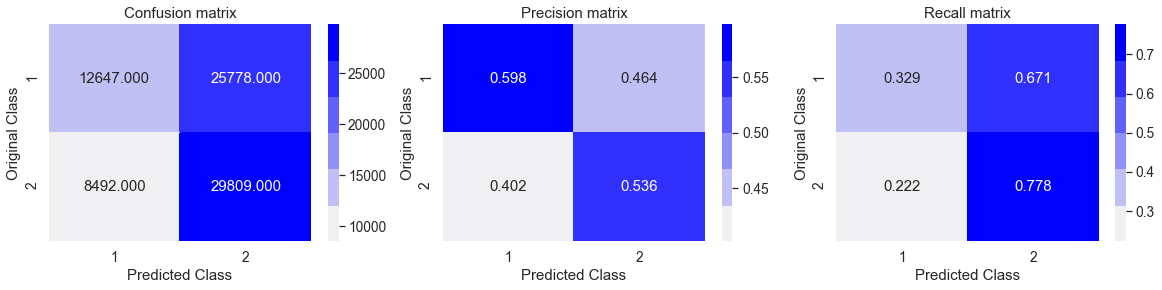

In [51]:
classifier = GaussianNB()
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
modelEvaluation(classifier,x_test, y_train, y_test, y_predict, x_train.columns)
plot_confusion_matrix(y_test, y_predict)

## Building a decision Tree model

Accurancy: 0.855
ROC AUC Score: 0.855
F1 Score:: 0.868 
Balanced Accurancy Score:: 0.855 

 clasification report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84     38425
           1       0.80      0.95      0.87     38301

    accuracy                           0.85     76726
   macro avg       0.87      0.86      0.85     76726
weighted avg       0.87      0.85      0.85     76726



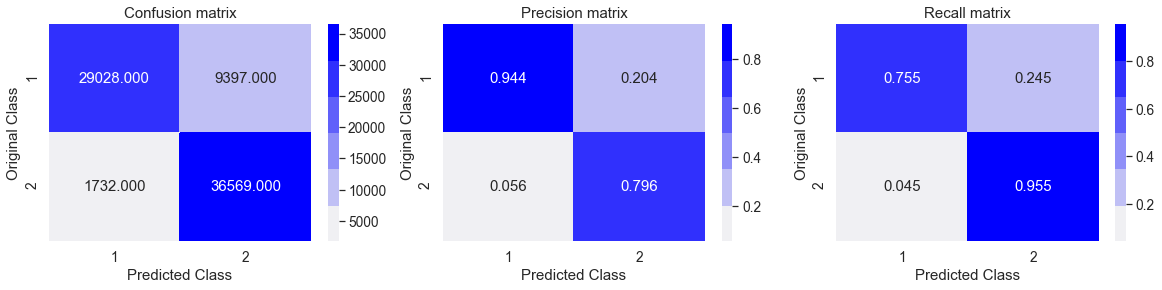

In [52]:
classifier  = tree.DecisionTreeClassifier()
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
modelEvaluation(classifier,x_test, y_train, y_test, y_predict, x_train.columns)
plot_confusion_matrix(y_test, y_predict)


## Building a logistic rehresssion model

c:\python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accurancy: 0.582
ROC AUC Score: 0.582
F1 Score:: 0.600 
Balanced Accurancy Score:: 0.582 

 clasification report:
               precision    recall  f1-score   support

           0       0.59      0.53      0.56     38425
           1       0.57      0.63      0.60     38301

    accuracy                           0.58     76726
   macro avg       0.58      0.58      0.58     76726
weighted avg       0.58      0.58      0.58     76726



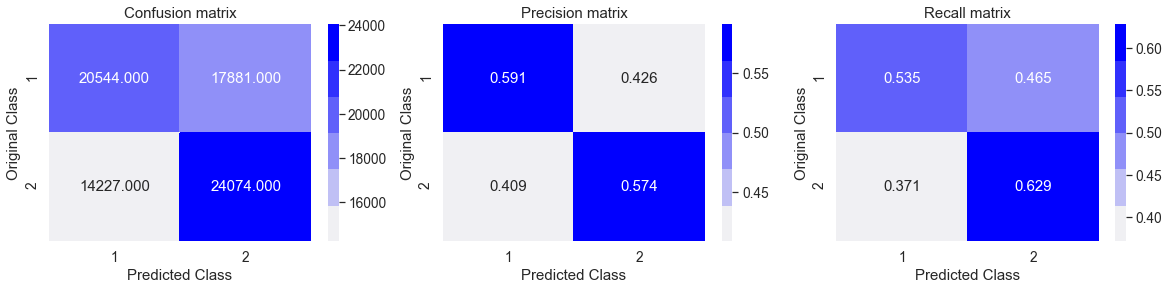

In [53]:

classifier  = LogisticRegression()
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
modelEvaluation(classifier,x_test, y_train, y_test, y_predict, x_train.columns)
plot_confusion_matrix(y_test, y_predict)

## Building a SGD model

c:\python36\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Accurancy: 0.486
ROC AUC Score: 0.486
F1 Score:: 0.372 
Balanced Accurancy Score:: 0.486 

 clasification report:
               precision    recall  f1-score   support

           0       0.49      0.67      0.57     38425
           1       0.48      0.30      0.37     38301

    accuracy                           0.49     76726
   macro avg       0.48      0.49      0.47     76726
weighted avg       0.48      0.49      0.47     76726



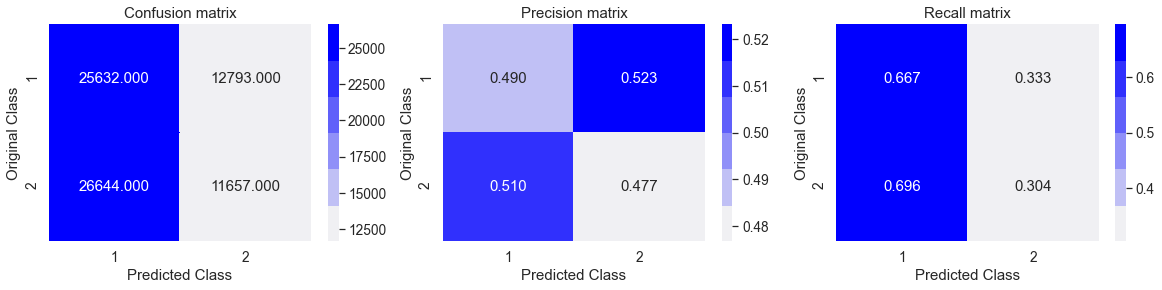

In [55]:

classifier  = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
modelEvaluation(classifier,x_test, y_train, y_test, y_predict, x_train.columns)
plot_confusion_matrix(y_test, y_predict)

## Building a random forest model

Accurancy: 0.940
ROC AUC Score: 0.940
F1 Score:: 0.940 
Balanced Accurancy Score:: 0.940 

 clasification report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94     38425
           1       0.93      0.95      0.94     38301

    accuracy                           0.94     76726
   macro avg       0.94      0.94      0.94     76726
weighted avg       0.94      0.94      0.94     76726



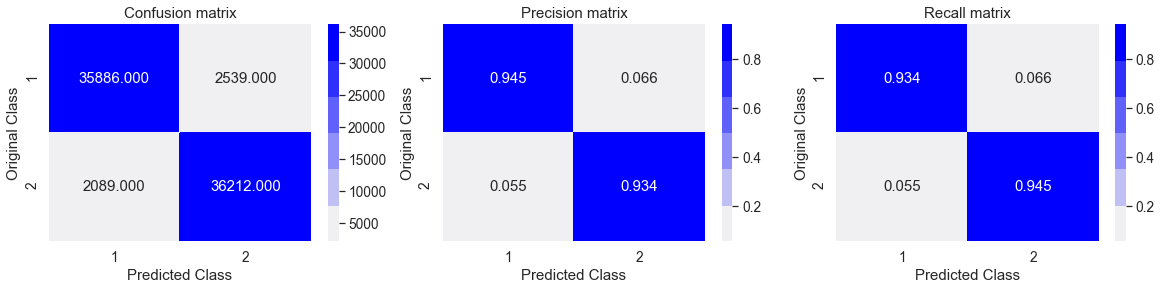

In [56]:

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
modelEvaluation(classifier,x_test, y_train, y_test, y_predict, x_train.columns)
plot_confusion_matrix(y_test, y_predict)

## Building a Ada Boost model

Accurancy: 0.615
ROC AUC Score: 0.615
F1 Score:: 0.625 
Balanced Accurancy Score:: 0.615 

 clasification report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60     38425
           1       0.61      0.64      0.62     38301

    accuracy                           0.61     76726
   macro avg       0.61      0.61      0.61     76726
weighted avg       0.62      0.61      0.61     76726



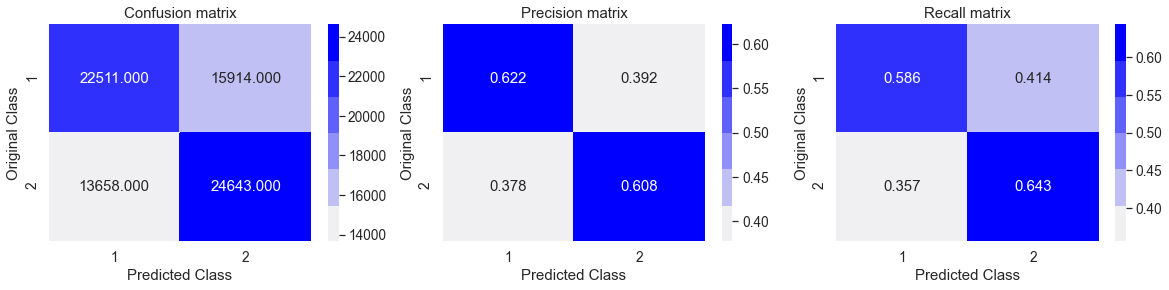

In [57]:


classifier =AdaBoostClassifier(n_estimators=100)
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
modelEvaluation(classifier,x_test, y_train, y_test, y_predict, x_train.columns)
plot_confusion_matrix(y_test, y_predict)

In [58]:
def scale_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

## Builing a Neura network Model

In [109]:


# create model
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation='relu'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history=model.fit(scale_data(x_train), y_train, validation_split=0.2, epochs=500, batch_size=512, verbose=1)

Train on 184142 samples, validate on 46036 samples
Epoch 1/500
184142/184142 [==============================] - 3s - loss: 0.8266 - acc: 0.5664 - val_loss: 0.8066 - val_acc: 0.5843
Epoch 2/500
184142/184142 [==============================] - 1s - loss: 0.7801 - acc: 0.5930 - val_loss: 0.7495 - val_acc: 0.5885
Epoch 3/500
184142/184142 [==============================] - 2s - loss: 0.7570 - acc: 0.6028 - val_loss: 0.7505 - val_acc: 0.6040
Epoch 4/500
184142/184142 [==============================] - 1s - loss: 0.7705 - acc: 0.5990 - val_loss: 0.7659 - val_acc: 0.6013
Epoch 5/500
184142/184142 [==============================] - 1s - loss: 0.7404 - acc: 0.6081 - val_loss: 0.7145 - val_acc: 0.6067
Epoch 6/500
184142/184142 [==============================] - 1s - loss: 0.7289 - acc: 0.6075 - val_loss: 0.7518 - val_acc: 0.6036
Epoch 7/500
184142/184142 [==============================] - 2s - loss: 0.8046 - acc: 0.5990 - val_loss: 0.8061 - val_acc: 0.5994
Epoch 8/500
184142/184142 [============

KeyboardInterrupt: 

## check best fetaures using chi

In [66]:
X_new = SelectKBest(chi2, k=5).fit(X, Y)

dfscores = [ round(i) for i in X_new.scores_]


df_best = pd.DataFrame(columns = ['Features','Score'])
df_best['Features'] = df.columns[:-1]
df_best['Score'] = dfscores
df_best.sort_values(by='Score',ascending=False).nlargest(10,'Score')


,Features,Score
31,SEC_INSTAL_AMT,29093070.0
25,SEC_ACTIVE_ACCTS,24138619.0
37,LOAN_DEFAULT,23779845.0
8,STATE_ID,10190088.0
27,SEC_CURRENT_BALANCE,3053869.0
35,CREDIT_HISTORY_LENGTH,1511160.0
30,PRIMARY_INSTAL_AMT,1493056.0
20,PRI_OVERDUE_ACCTS,672698.0
40,DisbursalAgeInDays,401648.0
13,VOTERID_FLAG,209645.0


## check best fetaures using info gain

In [61]:
new_df = pd.DataFrame()
new_df['column'] = [f'{i}' for i in X.columns]
new_df['inofrmation_gain'] = [info_gain.info_gain(df[i], Y) for i in X.columns]

In [67]:
new_df.sort_values(by='inofrmation_gain',ascending=False).reset_index().drop('index',axis=1).nlargest(10,'inofrmation_gain')

,column,inofrmation_gain
0,PRI_CURRENT_BALANCE,0.229142
1,ASSET_COST,0.171428
2,PRI_DISBURSED_AMOUNT,0.152177
3,PRI_SANCTIONED_AMOUNT,0.143275
4,PRIMARY_INSTAL_AMT,0.108934
5,DISBURSED_AMOUNT,0.099933
6,ApplicantAgeInDays,0.085665
7,CURRENT_PINCODE_ID,0.052855
8,LTV,0.043286
9,EMPLOYEE_CODE_ID,0.041768
